In [50]:
import os
import numpy as np
#%matplotlib inline
import matplotlib.pyplot as plt
plt.ion()

%load_ext autoreload
%autoreload 2
import nbodykit
import Corrfunc

from Corrfunc.mocks.DDsmu_mocks import DDsmu_mocks
from Corrfunc.utils import compute_amps
from Corrfunc.utils import evaluate_xi
from Corrfunc.bases import bao

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Tophat on mock data

### Set up parameters

Here we use a low-density lognormal simulation box.

In [72]:
boxsize = 750
nbar_str = '3e-4'
proj_type = 'tophat'

rmin = 40
rmax = 150
nbins = 11

mumax = 1.0
seed = 10
#weight_type='pair_product'
weight_type=None

In [73]:
rbins = np.linspace(rmin, rmax, nbins+1)
rcont = np.linspace(rmin, rmax, 1000)

cat_tag = '_L{}_nbar{}'.format(boxsize, nbar_str)
cat_dir = '../byebyebias/catalogs/cats_lognormal{}'.format(cat_tag)

cosmo = 1 #doesn't matter bc passing cz, but required
nthreads = 24
nmubins = 1
verbose = False

### Load in data and randoms

In [74]:
# data
datasky_fn = '{}/catsky_lognormal{}_seed{}.dat'.format(cat_dir, cat_tag, seed)
datasky = np.loadtxt(datasky_fn)
ra, dec, z = datasky.T
nd = datasky.shape[0]
#weights = np.full(nd, 0.5)
weights = None

In [75]:
# randoms
randsky_fn = '{}/randsky{}_10x.dat'.format(cat_dir, cat_tag)
randomsky = np.loadtxt(randsky_fn)
ra_rand, dec_rand, z_rand = randomsky.T
nr = randomsky.shape[0]
#weights_rand = np.full(nr, 0.5)
weights_rand = None

### Perform xi(s, mu) continous estimation

In [6]:
# projection
dd_res_corrfunc, dd_proj, _ = DDsmu_mocks(1, cosmo, nthreads, mumax, nmubins, rbins, ra, dec, z,
                is_comoving_dist=True, proj_type=proj_type, nprojbins=nbins, verbose=verbose, 
                weights1=weights, weight_type=weight_type)

dr_res_corrfunc, dr_proj, _ = DDsmu_mocks(0, cosmo, nthreads, mumax, nmubins, rbins, 
                ra, dec, z, RA2=ra_rand, DEC2=dec_rand, CZ2=z_rand, 
                is_comoving_dist=True, proj_type=proj_type, nprojbins=nbins, verbose=verbose,
                weights1=weights, weights2=weights_rand, weight_type=weight_type)

rr_res_corrfunc, rr_proj, qq_proj = DDsmu_mocks(1, cosmo, nthreads, mumax, nmubins, rbins, ra_rand, dec_rand, z_rand,
                is_comoving_dist=True, proj_type=proj_type, nprojbins=nbins, verbose=verbose,
                weights1=weights_rand, weight_type=weight_type)

Applying projection requires fallback method, switching instruction set
Applying projection requires fallback method, switching instruction set
Applying projection requires fallback method, switching instruction set


In [7]:
amps = compute_amps(nbins, nd, nd, nr, nr, dd_proj, dr_proj, dr_proj, rr_proj, qq_proj)
xi_proj = evaluate_xi(nbins, amps, len(rcont), rcont, len(rbins)-1, rbins, proj_type)

Computing amplitudes (Corrfunc/utils)
Evaluating xi (Corrfunc/utils)


### Perform xi(s, mu) standard estimation

In [8]:
def extract_counts(res, weight_type=None):
    counts = np.array([x[4] for x in res], dtype=float)
    if weight_type:
        weights = np.array([x[5] for x in res], dtype=float)
        counts *= weights
    return counts

In [9]:
# standard
proj_type = None
dd_res_corrfunc, _, _ = DDsmu_mocks(1, cosmo, nthreads, mumax, nmubins, rbins, ra, dec, z,
                is_comoving_dist=True, proj_type=proj_type, nprojbins=nbins, verbose=verbose,
                weights1=weights, weight_type=weight_type)
dd = extract_counts(dd_res_corrfunc, weight_type)

dr_res_corrfunc, _, _ = DDsmu_mocks(0, cosmo, nthreads, mumax, nmubins, rbins, 
                ra, dec, z, RA2=ra_rand, DEC2=dec_rand, CZ2=z_rand, 
                is_comoving_dist=True, proj_type=proj_type, nprojbins=nbins, verbose=verbose,
                weights1=weights, weights2=weights_rand, weight_type=weight_type)
dr = extract_counts(dr_res_corrfunc, weight_type)

rr_res_corrfunc, _, _ = DDsmu_mocks(1, cosmo, nthreads, mumax, nmubins, rbins, ra_rand, dec_rand, z_rand,
                is_comoving_dist=True, proj_type=proj_type, nprojbins=nbins, verbose=verbose,
                weights1=weights_rand, weight_type=weight_type)
rr = extract_counts(rr_res_corrfunc, weight_type)

In [10]:
fN = float(nr)/float(nd)
xi_ls = (dd * fN**2 - 2*dr * fN + rr)/rr
print("Standard L-S:")
print(xi_ls)

Standard L-S:
[ 9.07367349e-03  5.33148599e-03  3.11653563e-03  1.99330937e-03
  1.29004106e-03  8.66130331e-04  1.40126093e-03  8.48817853e-04
 -7.20140405e-04 -4.56320418e-05 -1.67193339e-04]


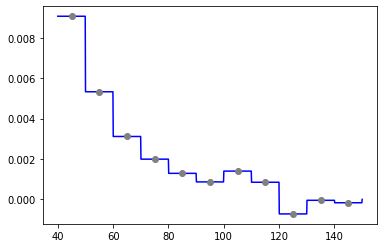

In [11]:
rbins_avg = 0.5*(rbins[1:]+rbins[:-1])
plt.plot(rcont, xi_proj, color='blue')
plt.plot(rbins_avg, xi_ls, marker='o', color='grey', ls='None')

# BAO on mock data

In [109]:
proj_type = 'generalr'
projfn = 'bao.dat'
# The spline routine writes to file, so remember to delete later
kwargs = {'cosmo_base':nbodykit.cosmology.Planck15, 'redshift':0}
nprojbins, _ = bao.write_bases(rbins[0], rbins[-1], projfn, **kwargs)

alpha_model: 1.02
dalpha: 0.005099999999999882
alpha_model: 1.02


Check out basis functions (normalized):

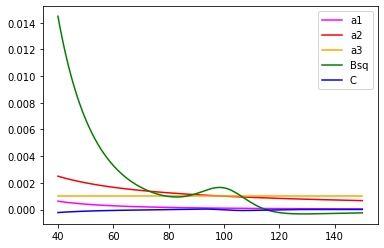

In [110]:
base_colors = ['magenta', 'red', 'orange', 'green', 'blue']
base_names = ['a1', 'a2', 'a3', 'Bsq', 'C']
bases = np.loadtxt(projfn)
bases.shape
r = bases[:,0]
for i in range(len(bases[0])-1):
    #norm = np.mean(bases[:,i])
    base = bases[:,i+1]
    plt.plot(r, base, color=base_colors[i], label='{}'.format(base_names[i]))
plt.legend()

In [111]:
_, dd_proj, _ = DDsmu_mocks(1, cosmo, nthreads, mumax, nmubins, rbins, ra, dec, z,
                is_comoving_dist=True, proj_type=proj_type, nprojbins=nprojbins, projfn=projfn,
                verbose=verbose, weights1=weights, weight_type=weight_type)

_, dr_proj, _ = DDsmu_mocks(0, cosmo, nthreads, mumax, nmubins, rbins, 
                ra, dec, z, RA2=ra_rand, DEC2=dec_rand, CZ2=z_rand, 
                is_comoving_dist=True, proj_type=proj_type, nprojbins=nprojbins, projfn=projfn, verbose=verbose,
                weights1=weights, weights2=weights_rand, weight_type=weight_type)

_, rr_proj, qq_proj = DDsmu_mocks(1, cosmo, nthreads, mumax, nmubins, rbins, ra_rand, dec_rand, z_rand,
                is_comoving_dist=True, proj_type=proj_type, nprojbins=nprojbins, projfn=projfn, verbose=verbose,
                weights1=weights_rand, weight_type=weight_type)

Applying projection requires fallback method, switching instruction set
Reading in projection file, bao.dat...
Read in 1000 by 6 basis data
Applying projection requires fallback method, switching instruction set
Reading in projection file, bao.dat...
Read in 1000 by 6 basis data
Applying projection requires fallback method, switching instruction set
Reading in projection file, bao.dat...
Read in 1000 by 6 basis data


In [112]:
amps = compute_amps(nprojbins, nd, nd, nr, nr, dd_proj, dr_proj, dr_proj, rr_proj, qq_proj)
print("amplitudes:",amps)
xi_proj = evaluate_xi(nprojbins, amps, len(rcont), rcont, len(rbins)-1, rbins, proj_type, projfn=projfn)

Computing amplitudes (Corrfunc/utils)
amplitudes: [ 0.828212   -0.87549388  0.50047871  1.04219122 -1.28994913]
Evaluating xi (Corrfunc/utils)
Reading in projection file, bao.dat...
Read in 1000 by 6 basis data


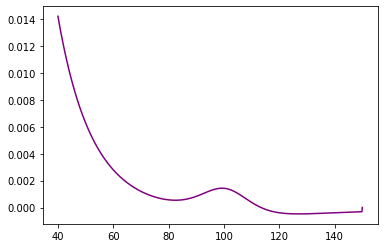

In [113]:
rbins_avg = 0.5*(rbins[1:]+rbins[:-1])
plt.plot(rcont, xi_proj, color='purple')
#plt.plot(rbins_avg, xi_ls, marker='o', color='grey', ls='None')

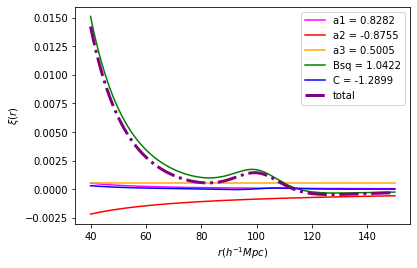

In [114]:
total = np.zeros(len(bases))
for i in range(0, bases.shape[1]-1):
    ampbase =  amps[i]*bases[:,i+1]
    total += ampbase
    plt.plot(rcont, ampbase, color=base_colors[i], label='{} = {:.4f}'.format(base_names[i], amps[i]))
plt.plot(r, total, color='purple', label='total', lw=3, ls='-.')
plt.xlabel(r'$r (h^{-1}Mpc)$')
plt.ylabel(r'$\xi(r)$')
plt.legend()

In [96]:
os.remove(projfn)

In [19]:
#!jupyter nbconvert --to script example.ipynb